# Preparation

In [1]:
!pip install Sastrawi

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

# Data

In [3]:
BASE_DIR = "/content/drive/My Drive/SM-Thesis/"

In [4]:
data = pd.read_csv(BASE_DIR + 'dataset/tweets.csv',
                   usecols=['text', 'original_author', 'label', 'label_'])

# Balancing Dataset

In [5]:
new_data = data.groupby(['original_author', 'label', 'label_'])['text'].apply(lambda x: '. '.join(x.astype(str))).reset_index()

In [6]:
# Class count
count_class_0, count_class_1 = new_data.label_.value_counts()

# Divide by class
df_class_0 = new_data[new_data['label_'] == 'genuine']
df_class_1 = new_data[new_data['label_'] == 'bot']

In [7]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
new_data = pd.concat([df_class_0, df_class_1_over], axis=0)
new_data = new_data.sample(frac=1).reset_index(drop=True)

Text(0.5, 1.0, 'Number of genuine and malicious accounts')

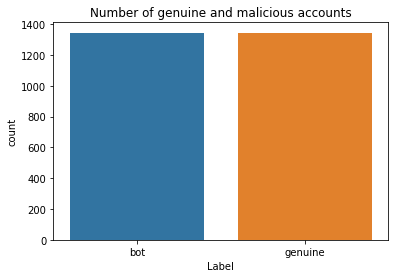

In [8]:
sns.countplot(new_data['label_'])
plt.xlabel('Label')
plt.title('Number of genuine and malicious accounts')

# Text Cleaning

In [9]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string, re

def clean_text(text):
    text = re.findall('[A-Z][^A-Z]*', str(text)) #split hashtag
    text_lc = " ".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[^A-Za-z0-9 ]+', '', text_lc)
    text = stopword.remove(text_rc)

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    return text

stopword = StopWordRemoverFactory().create_stop_word_remover()

new_data['text'] = new_data['text'].apply(lambda x: clean_text(x))
new_data['text'] = new_data['text'].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))

# Train

In [10]:
X, y = new_data.text.fillna(' ').values, new_data.label.values
#.reshape(-1,1)
# y = np.array([1 if i=='bot' else 0 for i in y])

In [11]:
def train_tweet(clf, X, y):
  df_score = pd.DataFrame(columns=cols_score)
  df_pred = pd.DataFrame(columns=['pred'])
  df_true = pd.DataFrame(columns=['true'])

  kf = KFold(n_splits=10, shuffle=True, random_state=1)
  i = 0
  j = 0
  for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    log = np.array([acc, prec, rec, f1, roc])
    # print("Accuracy: {:.4f}\nPrecision: {:.4f}\nRecall: {:.4f}\nF1 Score: {:.4f}\nROC/AUC Score: {:.4f}".format(acc, prec, rec, f1, roc))

    # y_test = ['bot' if i==1 else 'genuine' for i in y_test]
    # y_pred = ['bot' if i==1 else 'genuine' for i in y_pred]

    df_score.loc[i] = log
    df_pred.loc[:, j] = pd.Series(y_pred)
    df_true.loc[:, j] = pd.Series(y_test)
    i=i+1
    j=j+1
  return df_score, df_pred, df_true



In [12]:
classifiers = [LogisticRegression(random_state=19),
               BernoulliNB(),
               AdaBoostClassifier(n_estimators=100, random_state=19),
               RandomForestClassifier(random_state=19),
               DecisionTreeClassifier(random_state=19),
               MLPClassifier(random_state=19)]

In [13]:
cols_score = ["Accuracy", "Precision", "Recall", "F1-Score", "ROC/AUC"]

In [14]:
countvec = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
tfidfvec = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)

X_co = countvec.fit_transform(X).toarray()
X_tf = tfidfvec.fit_transform(X).toarray()

X_feat = [X_co, X_tf]
col = ['CountVec', 'TfidfVec']

for i, x in enumerate(X_feat):
  for j, clf in enumerate(classifiers):
    name = clf.__class__.__name__
    
    df_scores, df_preds, df_true = train_tweet(clf, x, y)
    df_scores.to_csv(BASE_DIR + 'Tweet Feature/new_score_' + col[i] + '_' + name + '.csv')
  #   df_preds.to_csv(BASE_DIR + 'Tweet Feature/pred_' + col[i] + '_' + name + '.csv')
  # df_true.to_csv(BASE_DIR + 'Tweet Feature/true_' + col[i] + '.csv')